In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import scipy

import numba

In [10]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"
# url_done="https://www.myinstants.com/media/sounds/tindeck_1.mp3"
# url_done="https://www.myinstants.com/media/sounds/dun_dun_1.mp3"


def allDone():
    display(Audio(url=url_done, autoplay=True,))

In [11]:
data_dir = os.path.join(os.getcwd(), "data")
drone_dir = os.path.join(data_dir, "tir_pavel")

In [12]:
video_files = ["pavel0.npy", "pavel1.npy", "pavel2.npy", "pavel3.npy"]

video0 = np.load(os.path.join(drone_dir, "pavel0.npy"))
video_np = []
for file in video_files:
    video_np.append(np.load(os.path.join(drone_dir, file)))

print(video0.shape)
print(video_np[0].shape)

(1144, 436, 496)
(1144, 436, 496)


In [13]:
import datetime as dt


timestamp_files = [
    "timestamp0.npy",
    "timestamp1.npy",
    "timestamp2.npy",
    "timestamp3.npy",
]

timestamp0 = np.load(os.path.join(drone_dir, "timestamp0.npy")).squeeze()
timestamp_np = []
for file in timestamp_files:
    timestamp_np.append(np.load(os.path.join(drone_dir, file)).squeeze())


def md(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum % 1) - dt.timedelta(days=366)
    return pd.Timestamp(day + dayfrac).round("S")


matlab_to_date = np.vectorize(md)
timestamp0 = matlab_to_date(timestamp0)

timestamp_np = map(matlab_to_date, timestamp_np)

In [14]:
video0_df = pd.DataFrame({"frames": [*video0]})
video0_df.index = timestamp0
video0_df

video_dfs = []
for video, timestamp in zip(video_np, timestamp_np):
    video_dfs.append(pd.DataFrame({"frames": [*video]}))
    video_dfs[-1].index = timestamp

video_dfs[0]

,frames
2019-08-06 12:29:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:37,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:38,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...
2019-08-06 12:48:33,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


#### merging the two:

making the data more coarse: 
* https://stackoverflow.com/a/39952846/6293070
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html 
* we probably want to resample down to half seconds? and take that average?

merging the two:
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html#pandas.merge_asof
* https://stackoverflow.com/a/43979285/6293070
    

In [15]:
label_df_1 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_1"), "/df")
label_df_2 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_2"), "/df")
label_df = pd.concat([label_df_1, label_df_2], axis=0)
print(label_df.shape)

(503881, 29)


In [16]:
label_df = label_df.resample("1S").median()
print(label_df.shape)

(1924190, 29)


In [17]:
print(pd.Timedelta("5S"))
print(pd.Timedelta("500L"))

0 days 00:00:05
0 days 00:00:00.500000


In [18]:
videos_w_labels = []

for video_df in video_dfs:
    videos_w_labels.append(
        pd.merge_asof(
            video_df,
            label_df,
            left_index=True,
            right_index=True,
            tolerance=pd.Timedelta("3S"),
            direction="nearest",
        )
    )


video0_df_w_labels = pd.merge_asof(
    video0_df,
    label_df,
    left_index=True,
    right_index=True,
    tolerance=pd.Timedelta("3S"),
    direction="nearest",
)

print(video0_df_w_labels.shape)
print(video0_df_w_labels.head(10))

(1144, 30)
                                                                frames  \
2019-08-06 12:29:34  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:35  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:36  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:37  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:38  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:39  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:40  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:41  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:42  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2019-08-06 12:29:43  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                            0         1        2         3         4  \
2019-08-06 12:29:34  15.47190  303.8815  19.6952  97.70690 -0.913253   
2019-08-06 12:29:35  15.47165 

In [19]:
any(video0_df_w_labels[23] == video0_df_w_labels[23].shift(1))

False

# Getting video and labels out of dataframe
* get out one thing for the labels, on thing for the video
* make sure that the video is just a 3d nparray

In [232]:
video = np.stack(video0_df_w_labels["frames"].to_list(), axis=0)
print(video.shape)

# video_np from earlier is already this...

(1144, 436, 496)


In [20]:
labels = [28]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

labels = video0_df_w_labels[labels].to_numpy()
print(labels.shape)

(1144, 1)


Somehow take the center of this:

for now just take width and height from shape
divide it by four

then take the middle half

In [21]:
# might not be the right order!


def get_middle(a):
    video0 = a
    frames, height, width = video0.shape

    cut_off = 4

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    video0 = video0[:, top:bottom, left:right]
    return video0

In [22]:
def replace_nan_with_mean(a):
    return np.where(np.isnan(a), np.ones_like(a) * np.nanmean(a), a)

detrending:
* take 30 seconds of video
* wow so detrend...
* for every frame find median value
* everything above median is white (1), everything below is black(0)

(626, 28, 31, 1)
(626, 28, 31)
1.6213766261413367
-1.5715870755981505
0.931345080452759
-0.025281401093776107


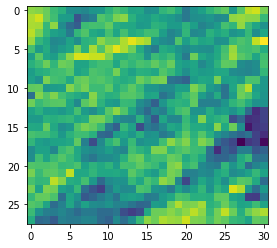

In [35]:
from scipy import signal
from functools import partial
from skimage.transform import rescale

print(video.shape)


def get_frame_middle(frame, cut_off):
    a = frame
    height, width = a.shape

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    return a[top:bottom, left:right]


def median_mask(b, n_dev):
    a = b
    std = np.std(a) * n_dev
    median = np.median(a)
    a[a < median - std] = median - std
    a[a >= median + std] = median + std
    return a


def moving_average(video, window_size):
    secs = np.arange(1, video.shape[0])
    mavgl = []
    for i in secs:
        if i >= window_size:
            mavgl.append(np.nanmean(video[i - window_size : i, :, :], axis=0))
        else:
            mavgl.append(np.nanmean(video[:i, :, :], axis=0))
    return np.stack(mavgl, axis=0)


# @numba.jit(nopython=True)
def sigmoid(a):
    return 1 / (1 + np.exp(-a))


def subtract_median(a):
    return a - np.median(a)


def subtract_from_frame(a, sub):
    return a - sub


def divide_by_std(a):
    return a / a.std()


def apply_to_outer_axis(a, func, args=[]):
    b = a
    for i in range(b.shape[0]):
        b[i] = func(b[i], *args)
    return b


def apply_funcs_to_outer_axis(a, funcs):
    """
    args:
    a: thing to apply over
    funcs: list of functions to apply over, can take args
        for example:
            funcs = [f_a, f_b]
            funcs = [(f_a, [1,2,3]), (f_b, [1])]
        a functions with args should be a pair with the args as a list
    """
    for i, f in enumerate(funcs):
        if callable(f):
            funcs[i] = (f, [])

    b = []
    for i in range(a.shape[0]):
        b.append(a[i])
        for f, args in funcs:
            b[i] = f(b[i], *args)
    return np.stack(b, axis=0)


# video = apply_to_outer_axis(video, median_mask)
# video = apply_funcs_to_outer_axis(
#     video, [(get_frame_middle, [4]), subtract_median, sigmoid]
# )

videos_processed = []
for video in video_np:
    video = replace_nan_with_mean(video)
    video = get_middle(video)
    video = (video - np.median(video)) / video.std()
    video = scipy.signal.detrend(video, axis=0)
    video = moving_average(video, 3)
    video = apply_to_outer_axis(video, subtract_median)
    video = apply_to_outer_axis(video, np.tanh)
    video = apply_to_outer_axis(video, median_mask, [2])
    video = apply_to_outer_axis(video, divide_by_std)
    b = []
    for i in range(video.shape[0]):
        b.append(rescale(video[i], 0.5, anti_aliasing=False))
    video = np.stack(b, axis=0)
    videos_processed.append(video)


# video = replace_nan_with_mean(video)
# video = get_middle(video)
# video = (video - np.median(video)) / video.std()
# video = scipy.signal.detrend(video, axis=0)
# video = moving_average(video, 3)
# video = apply_to_outer_axis(video, subtract_median)
# video = apply_to_outer_axis(video, np.tanh)
# video = apply_to_outer_axis(video, median_mask, [2])
# video = apply_to_outer_axis(video, divide_by_std)
# b = []
# for i in range(video.shape[0]):
#     b.append(rescale(video[i], 0.5, anti_aliasing=False))
# video = np.stack(b, axis=0)


print(video.shape)
print(video[0].max())
print(video[0].min())
print(video[0].std())
print(video[0].mean())

import matplotlib.pyplot as plt

plt.imshow(np.mean(video, axis=0))

# sucessfull video pre-processing stacks
* subtract_median, sigmoid, detrend_all, median_mask
* subtract_median, sigmoid, detrend_all, median_mask(2nd dev)

In [38]:
def Tensor_to_video(Tensor, path):
    Tensor = tf.where(
        tf.math.is_nan(Tensor),
        tf.ones_like(Tensor) * np.nanmean(Tensor.numpy()),
        Tensor,
    )
    video = tf.cast(255 * min_max_norm(Tensor), tf.uint8)
    frames, width, height = video.shape
    _fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(path, _fourcc, 10, (width, height))
    for i in range(frames):
        img = video[i, :, :]
        img = tf.repeat(tf.expand_dims(tf.transpose(img), axis=-1), 3, axis=2).numpy()
        out.write(img)


def min_max_norm(Tensor):
    min = tf.reduce_min(Tensor)
    max = tf.reduce_max(Tensor)
    return (Tensor - min) / (max - min)


# video_path = os.path.join(data_dir, "videos", "center_video.mp4")
# Tensor_to_video(tf.convert_to_tensor(video), video_path)

# from IPython.display import Video

# video_path = os.path.join(data_dir, "videos", "center_video.mp4")
# Video(video_path)

# allDone()

# things to try:
* how much to downsample?
* does our pre-processing do anything?
<!-- * do we need the whole image -->

In [39]:
video = np.stack(np.atleast_3d(*video), axis=0)

def add_axis_to_frames(a):
    return np.stack(np.atleast_3d(*a), axis=0)

videos_processed = list(map(add_axis_to_frames, videos_processed))


# ways to shape the data:
* one big list for everything
* 3d video chunks with a few consecutive frames

In [40]:
labels = [28]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

In [43]:
#one big list
video = np.concatenate(videos_processed, axis=0)
labels = np.concatenate(label_np, axis=0)

In [44]:
video.shape

(4083, 109, 124, 1)

In [45]:
def train_val_test(train, val, test, X, y):
    assert train + val + test == 1
    data_len = len(X)
    train_size = int(train * data_len)
    val_size = int(val * data_len)
    test_size = int(test * data_len)

    splits = [
        (0, train_size),
        (train_size, train_size + val_size),
        (train_size + val_size, data_len),
    ]

    x_out = []
    y_out = []
    for a, b in splits:
        x_out.append(X[a:b])
        y_out.append(y[a:b])

    return (*x_out, *y_out)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.1, 0.1, video, labels
)

In [46]:
from numpy.random import default_rng


def shuffle_dfs(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x[idx]
    y = y[idx]
    return x, y


# x_train, y_train = shuffle_dfs(x_train, y_train)

In [47]:
import tensorflow as tf

tf.random.set_seed(1234)
batch_size = 50

In [48]:
model = tf.keras.Sequential(
    [
        #         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(20, 30, activation="relu", input_shape=x_train[0].shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(10, 5, activation="relu", input_shape=x_train[0].shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        #             tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["accuracy", "mean_absolute_error"],
)

In [49]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=10, restore_best_weights=True
)

In [50]:
print(x_train.shape)
print(y_train.shape)

(3266, 109, 124, 1)
(3266, 1)


In [ ]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[callback],
)

Epoch 1/100
66/66 [==============================] - 8s 24ms/step - loss: 3089.1533 - accuracy: 0.0000e+00 - mean_absolute_error: 42.6202 - val_loss: 1751.5684 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 33.3710
Epoch 2/100
66/66 [==============================] - 1s 19ms/step - loss: 1427.2179 - accuracy: 0.0000e+00 - mean_absolute_error: 30.5871 - val_loss: 1417.1757 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 31.3337
Epoch 3/100
66/66 [==============================] - 1s 19ms/step - loss: 1381.3235 - accuracy: 0.0000e+00 - mean_absolute_error: 30.1863 - val_loss: 1381.8318 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 30.7204
Epoch 4/100
66/66 [==============================] - 1s 19ms/step - loss: 1414.5333 - accuracy: 0.0000e+00 - mean_absolute_error: 30.5188 - val_loss: 1752.7192 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 34.7179
Epoch 5/100
66/66 [==============================] - 1s 19ms/step - loss: 1372.0427 - accuracy: 0.0000e+00 - mea

In [ ]:
model.evaluate(x=x_test, y=y_test)

In [ ]:
preds = model.predict(x=x_test)

In [ ]:
def plot(l, r, preds, labels, width=20, height=7):
    assert len(preds) == len(labels)
    preds = preds[l:r]
    labels = labels[l:r]
    x = list(range(len(preds)))
    plt.rcParams["figure.figsize"] = [width, height]
    plt.scatter(x, labels, label="labels")
    plt.scatter(x, preds, label="predictions")
    plt.legend()
    plt.show()


plot(69, 420, preds, y_test)
allDone()